In [175]:
import os
import sys
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

unflagged_data = False

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import DESPIKED_DATA_DIRECTORY
from utils.config_files import load_json_config
from utils.import_data import import_acropolis_site_data
from config.sites_deloyment_times import deployment_times

assert(os.path.exists(DESPIKED_DATA_DIRECTORY))

# load files
config = load_json_config("config.json")

In [176]:
# import all sites with column "site" added
df_sites = []

# add datetime information
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
winter = list(range(355, 367)) + list(range(0, 80))

for site in config["icos_cities_portal"]["site_names"]:

    df_site = import_acropolis_site_data(target_directory=DESPIKED_DATA_DIRECTORY,
                                            deployment_times=deployment_times,
                                            site_name=site) \
            .filter(pl.col("Flag") == "U") \
            .select(["datetime", "gmp343_corrected"]) \
            .with_columns(site = pl.lit(site)) \
            .with_columns(
            pl.col("datetime")
            .dt.convert_time_zone("Europe/Berlin")
            .alias("datetime_local")) \
            .with_columns(pl.col("datetime_local").dt.ordinal_day().alias("day_of_year")) \
            .with_columns(
                pl.when(pl.col("day_of_year").is_in(spring)).then(pl.lit("spring"))
                .when(pl.col("day_of_year").is_in(summer)).then(pl.lit("summer"))
                .when(pl.col("day_of_year").is_in(fall)).then(pl.lit("fall"))
                .when(pl.col("day_of_year").is_in(winter)).then(pl.lit("winter"))
                .otherwise(None)
                .alias("season")
            ).group_by(["site", "season"]) \
            .agg(
                pl.col("gmp343_corrected").mean().alias("mean_co2"),
                pl.col("gmp343_corrected").median().alias("median_co2"),
                pl.col("gmp343_corrected").max().alias("max_co2"),
                pl.col("gmp343_corrected").min().alias("min_co2"),
                pl.col("gmp343_corrected").quantile(0.025).alias("q025_co2"),
                pl.col("gmp343_corrected").quantile(0.975).alias("q975_co2"),
                (pl.col("gmp343_corrected").max()- pl.col("gmp343_corrected").min()).alias("variation_co2"),
                pl.col("gmp343_corrected").std().alias("std_co2"),
                pl.col("gmp343_corrected").count().alias("count_co2"))
            
    df_sites.append(df_site)
    
df = pl.concat(df_sites)

In [177]:
df

site,season,mean_co2,median_co2,max_co2,min_co2,q025_co2,q975_co2,variation_co2,std_co2,count_co2
str,str,f64,f64,f64,f64,f64,f64,f64,f64,u32
"""TUMR""","""summer""",441.679699,434.92,566.95,408.57,416.97,503.43,158.38,22.597612,128171
"""TUMR""","""winter""",459.911331,451.29,678.59,426.28,433.27,546.84,252.31,28.574081,176921
"""TUMR""","""fall""",455.709093,451.31,693.13,415.11,424.63,523.98,278.02,24.19631,122983
"""TUMR""","""spring""",442.744176,438.91,570.09,400.29,424.16,481.01,169.8,15.017893,213564
"""FELR""","""spring""",445.38365,438.23,593.83,412.55,420.13,509.79,181.28,22.904517,228377
…,…,…,…,…,…,…,…,…,…,…
"""HARR""","""winter""",456.871997,451.83,569.29,419.74,436.03,508.9,149.55,18.253646,67007
"""HARR""","""fall""",458.068102,454.46,606.79,421.85,431.73,517.91,184.94,22.451206,79849
"""BALR""","""winter""",471.416554,456.54,747.61,413.18,435.22,580.55,334.43,38.814229,124716


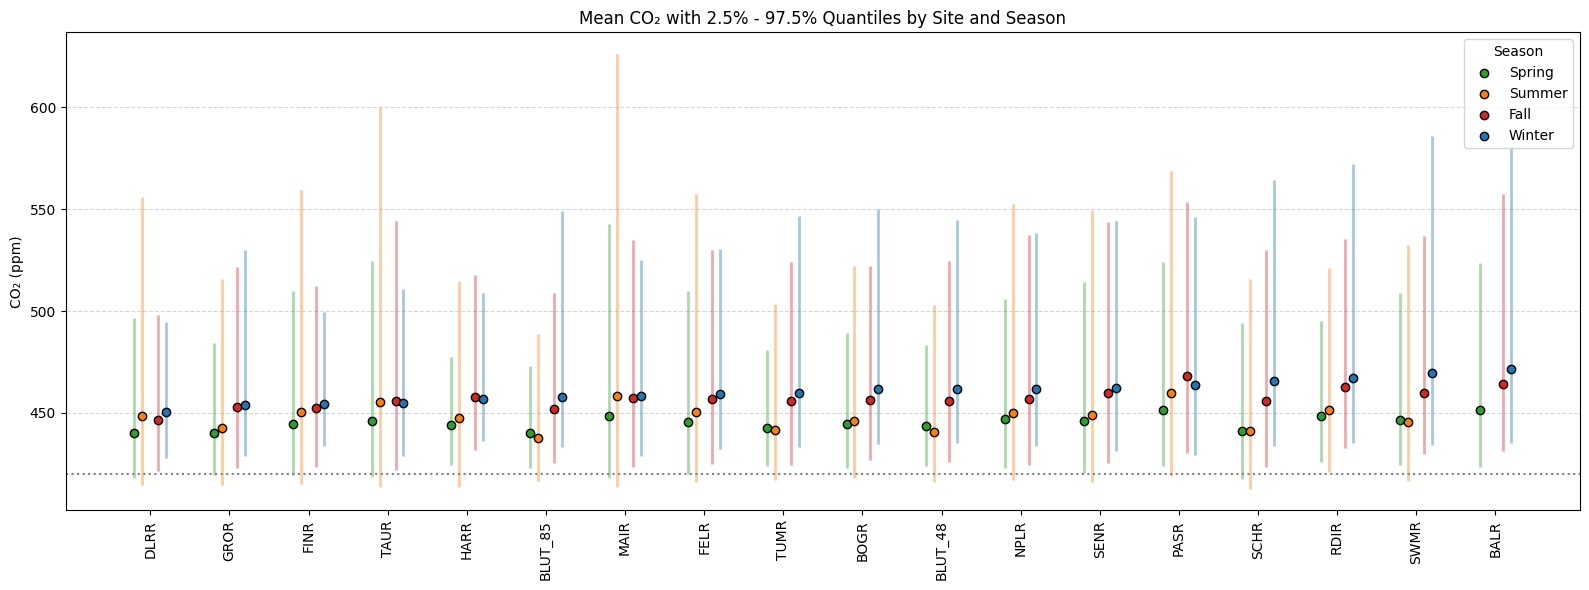

In [178]:
season_order = ["spring", "summer", "fall", "winter"]

season_colors = {
    "spring": "tab:green",
    "summer": "tab:orange",
    "fall":   "tab:red",
    "winter": "tab:blue"
}

# Sort sites by winter mean_co2
sites_order = (
    df.filter(pl.col("season") == "winter")
      .sort("mean_co2")
      .select("site")
      .to_series()
      .to_list()
)

# Create site index mapping
site_index_df = pl.DataFrame({
    "site": sites_order,
    "site_index": list(range(len(sites_order)))
})

# Join into df
df = df.join(site_index_df, on="site", how="inner")

# Offset expression per season
offset_expr = (
    pl.when(pl.col("season") == "spring").then(-0.2)
    .when(pl.col("season") == "summer").then(-0.1)
    .when(pl.col("season") == "fall").then(0.1)
    .when(pl.col("season") == "winter").then(0.2)
    .otherwise(0.0)
)

# Add x_val
df = df.with_columns(
    (pl.col("site_index") + offset_expr).alias("x_val")
)

plt.figure(figsize=(16, 6))
x_pos = np.arange(len(sites_order))

for season in season_order:
    subset = df.filter(pl.col("season") == season)
    
    x_vals = subset.get_column("x_val").to_numpy()
    min_vals = subset.get_column("q025_co2").to_numpy()
    max_vals = subset.get_column("q975_co2").to_numpy()
    mean_vals = subset.get_column("mean_co2").to_numpy()

    # Vertical line from min to max
    plt.vlines(
        x=x_vals,
        ymin=min_vals,
        ymax=max_vals,
        color=season_colors[season],
        alpha=0.4,
        linewidth=2
    )

    # Scatter mean
    plt.scatter(
        x_vals,
        mean_vals,
        label=season.capitalize(),
        color=season_colors[season],
        edgecolor="black",
        zorder=3
    )
    
# Add horizontal line at 420 ppm
plt.axhline(y=420, color="gray", linestyle="dotted", linewidth=1.5)


plt.xticks(x_pos, sites_order, rotation=90)
plt.ylabel("CO₂ (ppm)")
plt.title("Mean CO₂ with 2.5% - 97.5% Quantiles by Site and Season")
plt.legend(title="Season")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [179]:
# import all sites with column "site" added
df_sites = []

# add datetime information
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
winter = list(range(355, 367)) + list(range(0, 80))

for site in config["icos_cities_portal"]["site_names"]:

    df_site = import_acropolis_site_data(target_directory=DESPIKED_DATA_DIRECTORY,
                                            deployment_times=deployment_times,
                                            site_name=site) \
            .filter(pl.col("Flag") == "U") \
            .select(["datetime", "gmp343_corrected"]) \
            .with_columns(site = pl.lit(site)) \
            .with_columns(
            pl.col("datetime")
            .dt.convert_time_zone("Europe/Berlin")
            .alias("datetime_local")) \
            .with_columns(pl.col("datetime_local").dt.ordinal_day().alias("day_of_year")) \
            .group_by(["site"]) \
            .agg(
                pl.col("gmp343_corrected").mean().alias("mean_co2"),
                pl.col("gmp343_corrected").median().alias("median_co2"),
                pl.col("gmp343_corrected").max().alias("max_co2"),
                pl.col("gmp343_corrected").min().alias("min_co2"),
                pl.col("gmp343_corrected").quantile(0.025).alias("q025_co2"),
                pl.col("gmp343_corrected").quantile(0.975).alias("q975_co2"),
                (pl.col("gmp343_corrected").max()- pl.col("gmp343_corrected").min()).alias("variation_co2"),
                pl.col("gmp343_corrected").std().alias("std_co2"),
                pl.col("gmp343_corrected").count().alias("count_co2"))
            
    df_sites.append(df_site)
    
df = pl.concat(df_sites).sort("mean_co2")

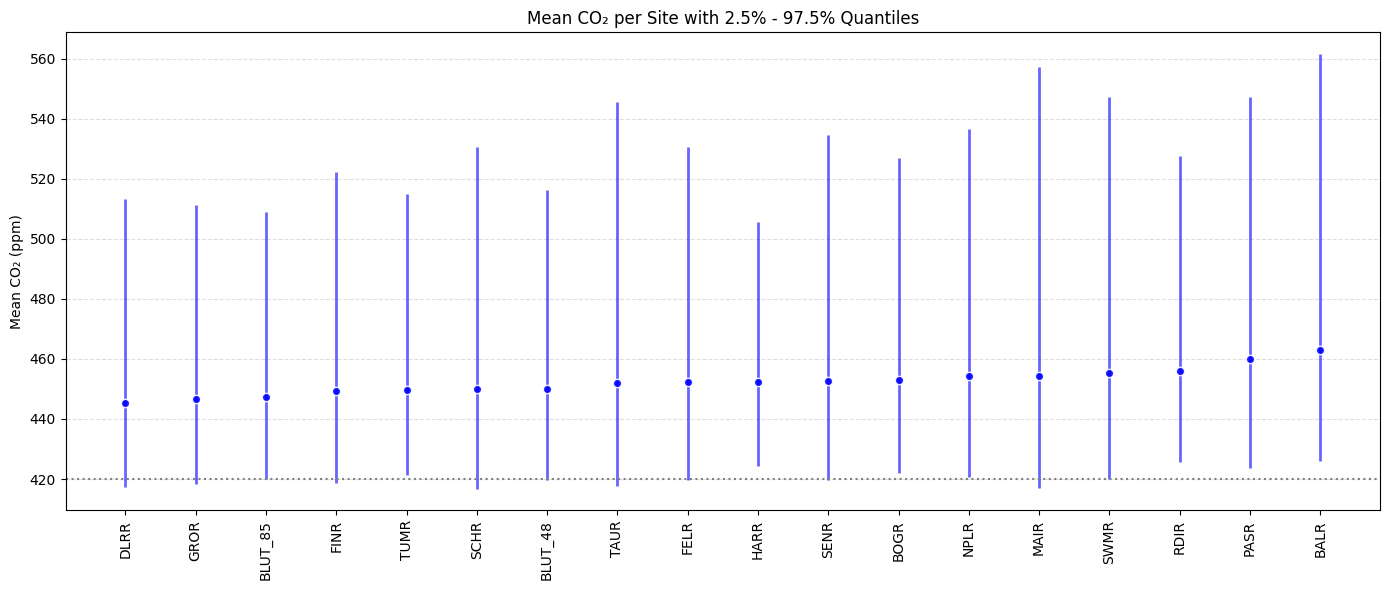

In [180]:
import matplotlib.pyplot as plt

# Assumes df contains: site, min_co2, max_co2, mean_co2
plt.figure(figsize=(14, 6))

site_labels = df.get_column("site").to_numpy()
x_vals = np.arange(len(site_labels))
min_vals = df.get_column("q025_co2").to_numpy()
max_vals = df.get_column("q975_co2").to_numpy()
mean_vals = df.get_column("mean_co2").to_numpy()

# Draw vertical lines from min to max
plt.vlines(
    x=x_vals,
    ymin=min_vals,
    ymax=max_vals,
    color="blue",
    alpha=0.6,
    linewidth=2
)

# Optional: mean as point
plt.scatter(
    x_vals,
    mean_vals,
    color="blue",
    edgecolor="white",
    alpha=0.9,
    zorder=3,
)

# Add horizontal line at 420 ppm
plt.axhline(y=420, color="gray", linestyle="dotted", linewidth=1.5)

# Label x-axis
plt.xticks(ticks=x_vals, labels=site_labels, rotation=90)
plt.ylabel("Mean CO₂ (ppm)")
plt.title("Mean CO₂ per Site with 2.5% - 97.5% Quantiles")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()